In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
cd /content/drive/MyDrive/idle_robotics/

/content/drive/MyDrive/idle_robotics


In [8]:
cd drive/MyDrive/idle_robotics/

/content/drive/MyDrive/idle_robotics


In [3]:
!pip install rasterio

In [4]:
!git clone https://github.com/magicleap/SuperGluePretrainedNetwork.git

Cloning into 'SuperGluePretrainedNetwork'...
^C


In [9]:
# cd SuperGluePretrainedNetwork


/content/drive/MyDrive/idle_robotics/SuperGluePretrainedNetwork


In [10]:
# !pip install -r requirements.txt

ERROR: Ignored the following yanked versions: 3.4.11.39, 3.4.17.61, 4.4.0.42, 4.4.0.44, 4.5.4.58, 4.5.5.62, 4.7.0.68
ERROR: Could not find a version that satisfies the requirement opencv-python==4.1.2.30 (from versions: 3.4.0.14, 3.4.10.37, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.57, 3.4.16.59, 3.4.17.63, 3.4.18.65, 4.3.0.38, 4.4.0.40, 4.4.0.46, 4.5.1.48, 4.5.3.56, 4.5.4.60, 4.5.5.64, 4.6.0.66, 4.7.0.72, 4.8.0.74, 4.8.0.76, 4.8.1.78, 4.9.0.80, 4.10.0.82, 4.10.0.84, 4.11.0.86, 4.12.0.88, 4.13.0.90)
ERROR: No matching distribution found for opencv-python==4.1.2.30


In [9]:
import os
import cv2
import torch
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, sin, cos, sqrt, atan2
from sklearn.model_selection import train_test_split


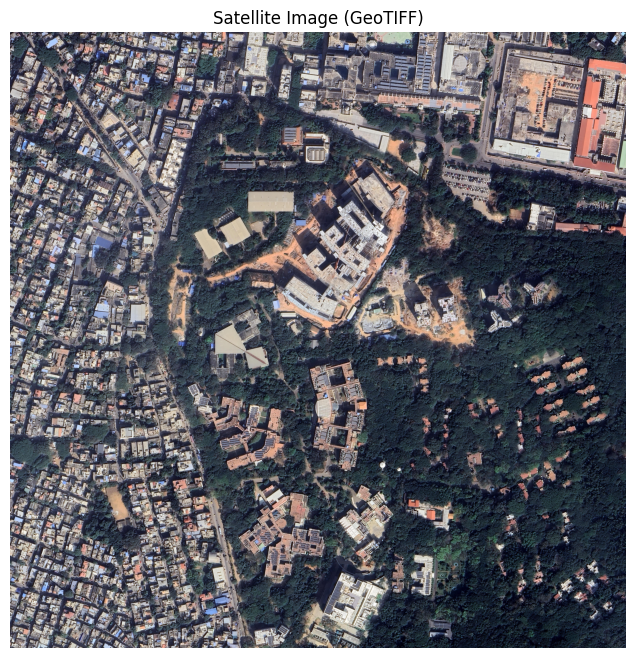

In [10]:
with rasterio.open("task_cv_model/map.tif") as src:
    sat_img = src.read([1,2,3]).transpose(1,2,0)
    geo_transform = src.transform

plt.figure(figsize=(8,8))
plt.imshow(sat_img)
plt.title("Satellite Image (GeoTIFF)")
plt.axis("off")
plt.show()


In [11]:
gt = pd.read_csv("task_cv_model/train_data/ground_truth.csv")
gt = gt.sort_values("timestamp").reset_index(drop=True)

def align_timestamp(img_ts, gt_df):
    idx = np.argmin(np.abs(gt_df["timestamp"].values - img_ts))
    return gt_df.iloc[idx]

In [12]:
img_ts = 1445.599225344
matched = align_timestamp(img_ts, gt)

print("Image TS:", img_ts)
print("Matched GPS TS:", matched.timestamp)
print("Lat/Lon:", matched.latitude, matched.longitude)

Image TS: 1445.599225344
Matched GPS TS: 1445.530336832
Lat/Lon: 13.026782435813065 77.56334879668483


In [13]:
import os
from sklearn.model_selection import train_test_split

samples = []

for name in os.listdir("task_cv_model/train_data/drone_images"):
    ts = float(os.path.splitext(name)[0])
    gt_row = align_timestamp(ts, gt)

    samples.append({
        "path": os.path.join("task_cv_model/train_data/drone_images", name),
        "timestamp": ts,
        "lat": gt_row.latitude,
        "lon": gt_row.longitude
    })

train_set, val_set = train_test_split(
    samples, test_size=0.2, random_state=42
)

print("Train:", len(train_set), "Val:", len(val_set))


Train: 400 Val: 100


In [16]:
import torch
from SuperGluePretrainedNetwork.models.superpoint import SuperPoint
from SuperGluePretrainedNetwork.models.superglue import SuperGlue

sp_config = {
    "descriptor_dim": 256,
    "nms_radius": 4,
    "keypoint_threshold": 0.001,
    "max_keypoints": 2048,
    "remove_borders": 4
}
sg_config = {
    "weights": "outdoor",
    "sinkhorn_iterations": 20,
    "match_threshold": 0.2
}
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)
superpoint = SuperPoint(sp_config).to(device).eval()
superglue = SuperGlue(sg_config).to(device).eval()

device: cuda
Loaded SuperPoint model
Loaded SuperGlue model ("outdoor" weights)


In [17]:
def extract_superpoint(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    inp = torch.from_numpy(gray/255.).float()[None,None].to(device)

    with torch.no_grad():
        out = superpoint({"image": inp})

    return (
        out["keypoints"][0],
        out["descriptors"][0],
        out["scores"][0]
    )


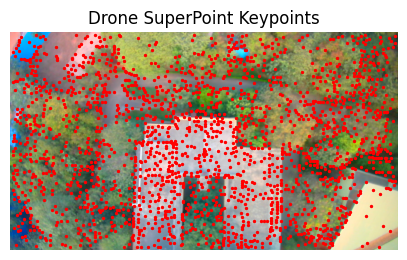

In [52]:
drone_img = cv2.imread(train_set[5]["path"])
kp, _, _ = extract_superpoint(drone_img)

plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(drone_img, cv2.COLOR_BGR2RGB))
plt.scatter(kp[:,0].cpu(), kp[:,1].cpu(), s=2, c="r")
plt.title("Drone SuperPoint Keypoints")
os.makedirs('output', exist_ok=True)
plt.savefig('output/SuperPoint_Keypoints.png')
plt.axis("off")
plt.show()


In [25]:
drone_img.shape

(720, 1280, 3)

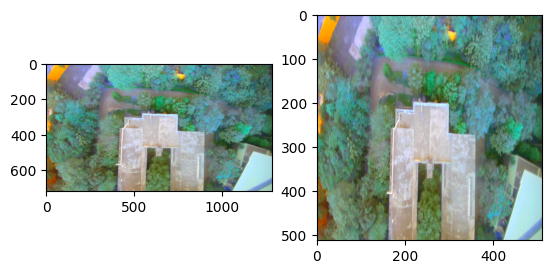

In [27]:
plt.subplot(121).imshow(drone_img)
drone_img_re = cv2.resize(drone_img, (512, 512))
plt.subplot(122).imshow(drone_img_re)

In [19]:
def superglue_match(img1, img2):
    k1, d1, s1 = extract_superpoint(img1)
    k2, d2, s2 = extract_superpoint(img2)

    data = {
        "keypoints0": k1[None],
        "keypoints1": k2[None],
        "descriptors0": d1[None],
        "descriptors1": d2[None],
        "scores0": s1[None],
        "scores1": s2[None],
        "image0": torch.empty((1,1,*img1.shape[:2]), device=device),
        "image1": torch.empty((1,1,*img2.shape[:2]), device=device),
    }

    with torch.no_grad():
        pred = superglue(data)

    matches = pred["matches0"][0].cpu().numpy()
    valid = matches > -1

    return (
        k1[valid].cpu().numpy(),
        k2[matches[valid]].cpu().numpy()
    )


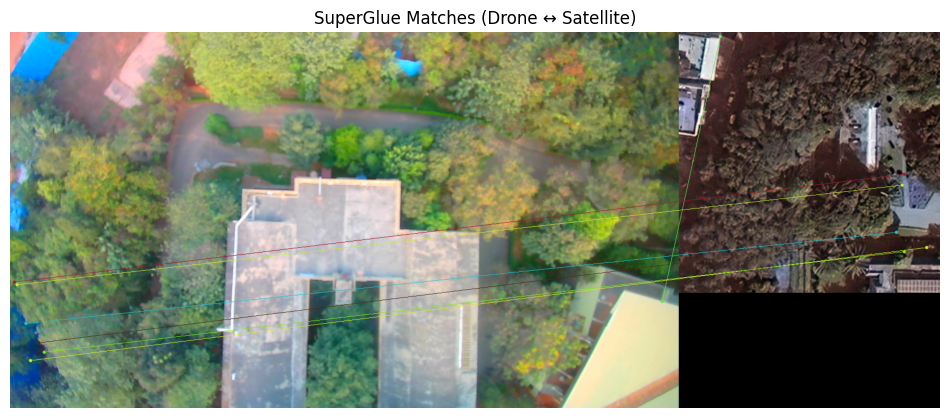

In [53]:
def visualize_matches(img1, pts1, img2, pts2, max_lines=50):
    """
    img1, img2 : BGR images
    pts1, pts2 : (N,2) matched points
    """
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    canvas = np.zeros((max(h1, h2), w1 + w2, 3), dtype=np.uint8)
    canvas[:h1, :w1] = img1
    canvas[:h2, w1:] = img2

    n = min(len(pts1), max_lines)

    for i in range(n):
        p1 = tuple(pts1[i].astype(int))
        p2 = (int(pts2[i][0] + w1), int(pts2[i][1]))

        color = tuple(np.random.randint(0,255,3).tolist())
        cv2.circle(canvas, p1, 3, color, -1)
        cv2.circle(canvas, p2, 3, color, -1)
        cv2.line(canvas, p1, p2, color, 1)

    return canvas
patch = sat_img[1000:1500, 2000:2500]
mk0, mk1 = superglue_match(drone_img, patch)
# mk0, mk1 = superglue_match(drone_img, patch)

vis = visualize_matches(drone_img, mk0, patch, mk1)

plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("SuperGlue Matches (Drone ↔ Satellite)")
plt.axis("off")
plt.savefig('output/SuperPoint_Matches_random_patch.png')
plt.show()



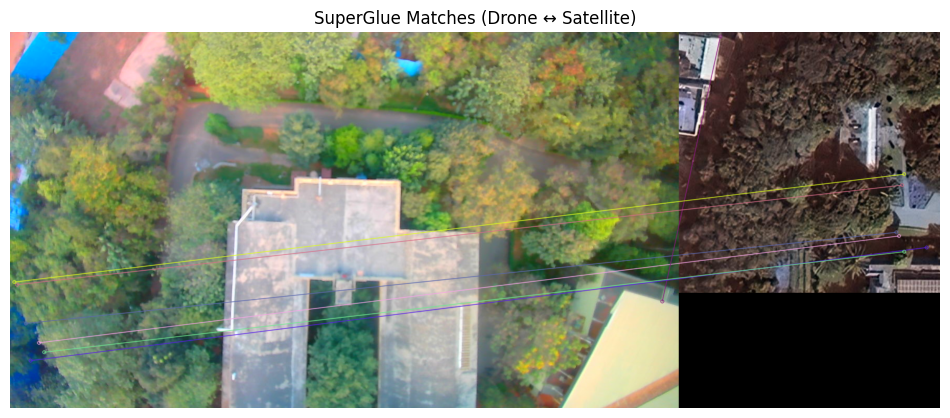

In [21]:
kp1 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in mk0]
kp2 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in mk1]

matches = [cv2.DMatch(i, i, 0) for i in range(len(kp1))]

vis = cv2.drawMatches(
    drone_img, kp1,
    patch, kp2,
    matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("SuperGlue Matches (Drone ↔ Satellite)")
plt.axis("off")
plt.show()

In [44]:
def is_homography_valid(H, img_shape):
    h, w = img_shape[:2]

    corners = np.array([
        [0, 0, 1],
        [w, 0, 1],
        [w, h, 1],
        [0, h, 1]
    ]).T

    warped = H @ corners
    warped /= warped[2]

    xs = warped[0]
    ys = warped[1]

    # Reject if extreme distortion
    if np.any(np.isnan(xs)) or np.any(np.isnan(ys)):
        return False

    area = cv2.contourArea(
        np.vstack([xs, ys]).T.astype(np.float32)
    )

    if area < 0.05 * (w * h):
        return False

    if area > 10 * (w * h):
        return False

    return True
def estimate_best_satellite_patch(
    drone_img, sat_img,
    window=512, stride=256
):
    best = None
    best_inliers = 0
    drone_img = cv2.resize(drone_img, (window, window))
    for y in range(0, sat_img.shape[0]-window, stride):
        for x in range(0, sat_img.shape[1]-window, stride):
            patch = sat_img[y:y+window, x:x+window]

            mk0, mk1 = superglue_match(drone_img, patch)
            if len(mk0) < 12:
                continue

            H, mask = cv2.findHomography(mk0, mk1, cv2.RANSAC, 5.0)
            H, mask = cv2.findHomography(mk0, mk1, cv2.RANSAC, 5.0)
            if H is None:
                continue

            if not is_homography_valid(H, drone_img.shape):
                continue

            inliers = int(mask.sum())
            if inliers > best_inliers:
                best_inliers = inliers
                best = {
                    "H": H,
                    "x": x,
                    "y": y,
                    "patch": patch,
                    "inliers": inliers
                }

    return best


In [45]:
import os
import numpy as np

def save_best_inlier_npz(best, save_dir, image_id):
    os.makedirs(save_dir, exist_ok=True)

    np.savez(
        os.path.join(save_dir, f"{image_id}_best_inlier.npz"),
        H=best["H"],
        x=best["x"],
        y=best["y"],
        patch=best["patch"],
        # mk0=best["mk0"],
        # mk1=best["mk1"],
        inliersk=best["inliers"],
        # num_inliers=best["num_inliers"]
    )

In [60]:
drone_img = cv2.resize(drone_img, (512, 512))
best = estimate_best_satellite_patch(drone_img, sat_img)



KeyboardInterrupt: 

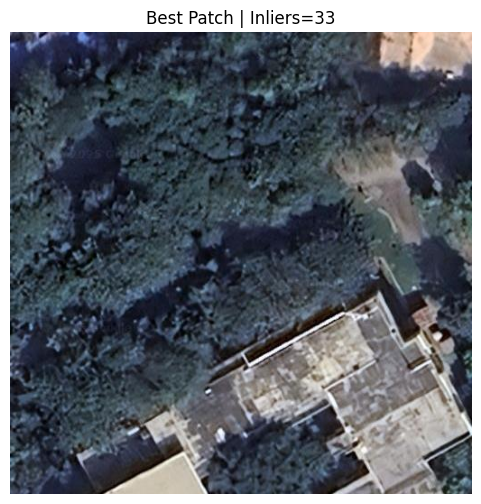

In [61]:
plt.figure(figsize=(6,6))
plt.imshow(best["patch"])
plt.title(f"Best Patch | Inliers={best['inliers']}")
plt.axis("off")
plt.savefig('output/best_patch_satellite.png')
plt.show()

In [47]:
drone_img.shape

(512, 512, 3)

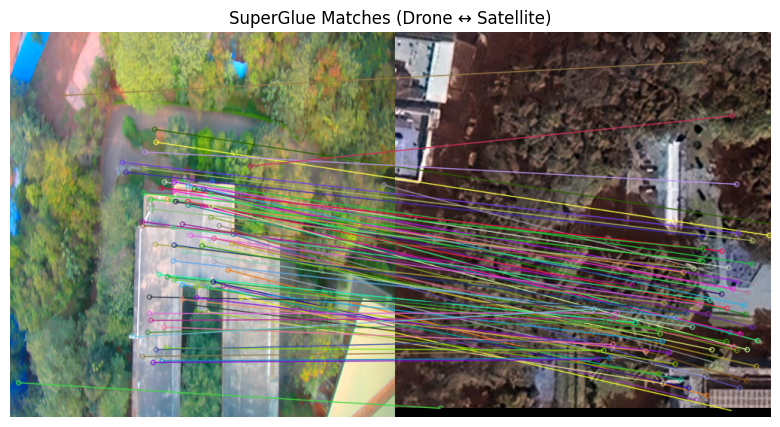

In [62]:
mk0, mk1 = superglue_match(drone_img, best['patch'])
kp1 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in mk0]
kp2 = [cv2.KeyPoint(x=float(p[0]), y=float(p[1]), size=1) for p in mk1]

matches = [cv2.DMatch(i, i, 0) for i in range(len(kp1))]

vis = cv2.drawMatches(
    drone_img, kp1,
    patch, kp2,
    matches, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)
plt.figure(figsize=(12,5))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title("SuperGlue Matches (Drone ↔ Satellite)")
plt.axis("off")
plt.savefig('output/SuperPoint_Matches_best_patch.png')
plt.show()

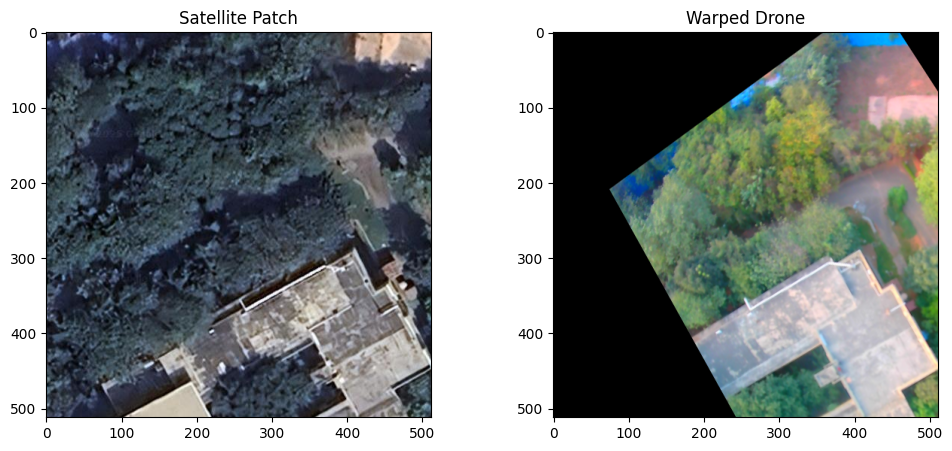

In [63]:
warped = cv2.warpPerspective(
    drone_img, best["H"],
    (best["patch"].shape[1], best["patch"].shape[0])
)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(best["patch"])
plt.title("Satellite Patch")

plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.title("Warped Drone")
plt.savefig('output/Wrapped_drone_image.png')
plt.show()


In [64]:
image_id = os.path.splitext(os.path.basename(train_set[0]["path"]))[0]
save_best_inlier_npz(best, "output_dir", image_id)

In [65]:
def align_drone_to_satellite(drone_img, sat_img, path):
    best = estimate_best_satellite_patch(drone_img, sat_img)
    image_id = os.path.splitext(os.path.basename(path))[0]
    save_best_inlier_npz(best, "output_dir", image_id)
    if best is None:
        return None

    h, w = drone_img.shape[:2]
    center = np.array([[w/2, h/2, 1]]).T
    mapped = best["H"] @ center
    mapped /= mapped[2]

    px = mapped[0] + best["x"]
    py = mapped[1] + best["y"]

    lon, lat = geo_transform * (px, py)
    return lat, lon


def haversine(lat1, lon1, lat2, lon2):
    R = 6371000
    dlat = radians(lat2-lat1)
    dlon = radians(lon2-lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1))*cos(radians(lat2))*sin(dlon/2)**2
    return 2*R*atan2(sqrt(a), sqrt(1-a))


In [66]:
from tqdm import tqdm
import numpy as np
from math import radians, sin, cos, sqrt, atan2

def evaluate(dataset, desc="Evaluating"):
    errors = []
    success = 0

    for sample in tqdm(dataset, desc=desc, total=len(dataset)):
        drone = cv2.imread(sample["path"])
        pred = align_drone_to_satellite(drone, sat_img, sample['path'])

        if pred is None:
            continue

        err = haversine(
            pred[0], pred[1],
            sample["lat"], sample["lon"]
        )

        errors.append(err)
        success += 1

    if success == 0:
        return {
            "mean_error_m": None,
            "median_error_m": None,
            "num_samples": 0
        }

    return {
        "mean_error_m": float(np.mean(errors)),
        "median_error_m": float(np.median(errors)),
        "num_samples": success
    }


In [ ]:
print("Train:", evaluate(train_set))

In [ ]:
print("Val:", evaluate(val_set))